In [72]:
import numpy as np
import pandas as pd
import os
from statsmodels.stats.weightstats import ztest
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
path = os.listdir('./')
path

['.ipynb_checkpoints',
 'sample_submission_0_1.csv',
 'shopee market analysis.ipynb',
 'student-shopee-code-league-marketing-analytics.zip',
 'test.csv',
 'train.csv',
 'users.csv']

In [126]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
users = pd.read_csv('users.csv')
sample = pd.read_csv('sample_submission_0_1.csv')

In [127]:
#將users的資料加入資料集
train = train.join(users, on = 'user_id', rsuffix = '_').drop(['user_id_'], axis = 1)
test = test.join(users, on = 'user_id', rsuffix = '_').drop(['user_id_'], axis = 1)

#合併train和test為資料集
data_set = pd.concat([train.drop(['open_flag'], axis = 1), test]) 

data_set數量比users的資料還多, 代表data_set中有相同的用戶收到複數信件, 相同的用戶應有相同行為

In [126]:
print('train\'s shape : ',train.shape)
print('test\'s shape : ',test.shape)
print('users\' shape : ', users.shape)
print('data_set\'s shape : ',data_set.shape)
print('open_ratio : ', train['open_flag'].value_counts(normalize = True).values)

train's shape :  (73539, 23)
test's shape :  (55970, 22)
users' shape :  (127886, 6)
data_set's shape :  (129509, 22)
open_ratio :  [0.84421871 0.15578129]


In [112]:
display(train.head())
display(users.head())

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,attr_1,attr_2,attr_3,age,domain
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,...,0,5,10,0,0,1.0,1.0,2.0,47.0,@gmail.com
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,...,1,1,4,1,1,1.0,1.0,2.0,25.0,@hotmail.com
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,...,5,19,27,0,2,NaN,1.0,0.0,NaN,@yahoo.com
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,...,1,3,6,0,3,1.0,1.0,2.0,24.0,@yahoo.com
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,...,0,0,0,0,4,NaN,1.0,0.0,NaN,@hotmail.com


,user_id,attr_1,attr_2,attr_3,age,domain
0,0,NaN,1.0,0.0,NaN,@gmail.com
1,1,1.0,1.0,2.0,50.0,@gmail.com
2,2,NaN,1.0,0.0,NaN,other
3,3,NaN,1.0,0.0,NaN,@gmail.com
4,4,1.0,1.0,2.0,33.0,@gmail.com


**目標** : 預測郵件是否會被打開


**data** : 

country_code : 城市代碼

grass_date : 郵件發送時間(不同日期相同時間) => 刪掉 or 轉換為假日平日

user_id : 使用者代號(key of join)

subject_line_length : 郵件標題的長度

last_open_day : 離上次打開郵件過了幾天(有出現Never open, target卻為1 => 將其改為0並移出trainset) 

last_login_day : 離上次登入過了幾天

last_checkout_day : 離上次在蝦皮消費過了幾天

open_count_last_n_days : 過去n天內使用者打開信件的次數

open_login_last_n_days : 過去n天內使用者登入帳戶的次數

open_checkout_last_n_days : 過去n天內使用者在蝦皮消費的次數

open_flag : 打開(1)未打開(0)

attr_1/2 : 用戶的某種屬性(未知) boolen

attr_3 : 用戶的某種屬性(未知) categorical [0,1,2,3,4]

age : 用戶年齡

domain : 用戶信箱的網域

**country_code**

range : 1,2,3,4,5,6,7分別代表一個城市



In [25]:
#用戶在各城市的數量
data_set['country_code'].value_counts()

1    44754
3    28198
2    24203
4    10848
5     9994
6     6727
7     4785
Name: country_code, dtype: int64

**grass_date**

不同郵件寄出的時間除了日期都相同

不同天/不同月的open ratio(open/not open)差不多(0.2左右)

取出月份和天數, 並把天數轉為假日/平日

**subject_line_length**

大致呈現normal, 集中在30~50

標題長度應該不太會影響open, 重要的是標題內容 => remove

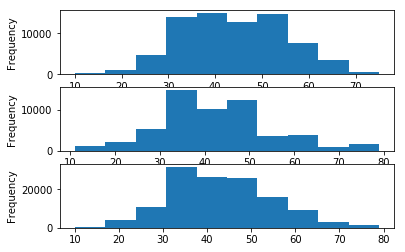

In [108]:
plt.subplot(311)
train['subject_line_length'].plot(kind = 'hist')
plt.subplot(312)
test['subject_line_length'].plot(kind = 'hist')
plt.subplot(313)
data_set['subject_line_length'].plot(kind = 'hist')

**last_open/login/checkout_day**

除了數值以外還有never open/login/checkout, 直接轉為-1

**open/login/checkout_count_n_days**

以天數做normalization

In [30]:
for t in ['open', 'login', 'checkout']:
    print(f'open ratio of Never {t} :', 
    train[(train[f'last_{t}_day'] == f'Never {t}')]['open_flag'].value_counts(normalize = True).iloc[1])

open ratio of Never open : 0.061585528065975
open ratio of Never login : 0.26523297491039427
open ratio of Never checkout : 0.1380656610470275


**attr_1**

發現attr_1為nan時, age也都為nan

attr_1大部分都為1且為0時沒有提供有用資訊, 而attr_1為nan時open_ratio與為1時相似 => nan補1

In [165]:
#attr_1為nan與age為nan的數量相同
data_set['attr_1'].isna().sum() - data_set['age'].isna().sum()

0

In [172]:
#attr_1大部分都為1
data_set['attr_1'].value_counts(dropna = False)

1.0    79998
NaN    49497
0.0       14
Name: attr_1, dtype: int64

In [167]:
print('open_ratio_of_nan : ',
      train[train['attr_1'].isna()]['open_flag'].value_counts(normalize = True).iloc[1])
print('open_ratio_of_not_nan : ',
        train[train['attr_1'] == 1]['open_flag'].value_counts(normalize = True).iloc[1])

open_ratio_of_nan :  0.15629386991109032
open_ratio_of_not_nan :  0.15549386898647025


**attr_2**

大部分都為1, 且不同值之間的open_ratio差異不大 => 可以remove

In [6]:
#大部分為2
data_set['attr_2'].value_counts(dropna = False)

1.0    128762
NaN       491
0.0       256
Name: attr_2, dtype: int64

In [7]:
#open ratio差異不大
print('open_ratio_of_nan : ',
      train[train['attr_2'].isna()]['open_flag'].value_counts(normalize = True).iloc[1])
print('open_ratio_of_1 : ',
        train[train['attr_2'] == 1]['open_flag'].value_counts(normalize = True).iloc[1])
print('open_ratio_of_0 : ',
        train[train['attr_2'] == 0]['open_flag'].value_counts(normalize = True).iloc[1])

open_ratio_of_nan :  0.1865079365079365
open_ratio_of_1 :  0.15571416851259332
open_ratio_of_0 :  0.13725490196078433


**attr_3**

nan只占不到1%, 大部分為0,1,2

不同數值間的open ratio差不多 => nan直接補0就好

In [9]:
#nan佔極少數
data_set['attr_3'].value_counts(dropna = False, normalize = True)

0.0    0.382051
2.0    0.318488
1.0    0.242323
4.0    0.029813
3.0    0.027017
NaN    0.000309
Name: attr_3, dtype: float64

In [10]:
#open ratio差異不大
for i in range(5):
    print(f'open_ratio_of_{i}', 
          train[train['attr_3'] == i]['open_flag'].value_counts(normalize = True).iloc[1])

open_ratio_of_0 0.1562668779029993
open_ratio_of_1 0.1548016934046346
open_ratio_of_2 0.15592286501377411
open_ratio_of_3 0.15227159261108336
open_ratio_of_4 0.15945330296127563


In [13]:
#attr_3 fill nan with 0
train['attr_3'] = train['attr_3'].fillna(0)
test['attr_3'] = test['attr_3'].fillna(0)
data_set['attr_3'] = data_set['attr_3'].fillna(0)

**age**

存在outlier => 小於18或大於90轉成nan

6X%的資料為nan, 補 -1

open與not open的年齡分佈差異不大 => 合理

nan和not nan的open ratio差異不大


In [20]:
#有60%的data為nan
print('ratio of nan/not nan : ',data_set['age'].isna().sum()/(~data_set['age'].isna()).sum())

ratio of nan/not nan :  0.6186197070439434


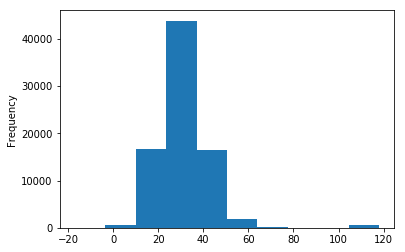

In [21]:
#年齡不可能為負或是一百多 => 存在outlier
data_set['age'].plot(kind = 'hist')

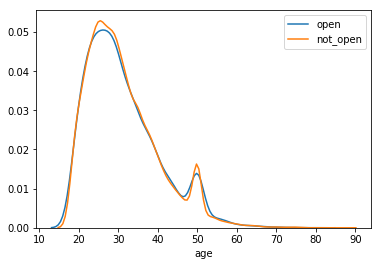

In [31]:
#open和not open的年齡分佈差異不大
train_open = train[train['open_flag'] == 1]
train_not_open = train[train['open_flag'] == 0]
sns.distplot(train_open['age'], hist = False, label = 'open')
sns.distplot(train_not_open['age'], hist = False, label = 'not_open')

In [32]:
#open ratio在nan與not nan差異不大
print('open ratio of nan : ',
      train[train['age'].isna()]['open_flag'].value_counts(normalize = True).iloc[1])
print('open ratio of non nan : ',
      train[~train['age'].isna()]['open_flag'].value_counts(normalize = True).iloc[1])

open ratio of nan :  0.156185424989668
open ratio of non nan :  0.15551760555468172


**domain**

85%為gmail, nan只有0.01% => 轉為other

rocketmail.com的open ratio較高其他則差不多

rocketmail.com於2013年停止申請

In [36]:
data_set['domain'].value_counts(normalize = True, dropna = False)

@gmail.com         0.846814
@yahoo.com         0.074088
@hotmail.com       0.038777
other              0.017358
@icloud.com        0.006208
@qq.com            0.005946
@outlook.com       0.003212
@ymail.com         0.002664
@live.com          0.002363
@163.com           0.001390
@rocketmail.com    0.000873
NaN                0.000309
Name: domain, dtype: float64

In [44]:
#@rocketmail.com的open ratio較大, 其他的則差不多
train.groupby('domain')['open_flag'].value_counts(normalize = True, dropna = False)

domain           open_flag
@163.com         0            0.838384
                 1            0.161616
@gmail.com       0            0.845101
                 1            0.154899
@hotmail.com     0            0.835377
                 1            0.164623
@icloud.com      0            0.850220
                 1            0.149780
@live.com        0            0.828402
                 1            0.171598
@outlook.com     0            0.844898
                 1            0.155102
@qq.com          0            0.846154
                 1            0.153846
@rocketmail.com  0            0.797101
                 1            0.202899
@yahoo.com       0            0.837201
                 1            0.162799
@ymail.com       0            0.826316
                 1            0.173684
other            0            0.856444
                 1            0.143556
Name: open_flag, dtype: float64

In [128]:
def data_clean(df):
    #處理grass_date
    def adjust_date(df):
        df['grass_date'] = pd.to_datetime(df['grass_date'])
        df['day_of_week'] = df['grass_date'].dt.dayofweek.astype('category')
        df['month'] = df['grass_date'].dt.month.astype('category')    
        #將天數轉為假日/平日
        df['is_busday'] = df['grass_date'].apply(lambda x : np.is_busday(x.strftime('%Y-%m-%d'))).astype('int64')
        df = df.drop(['grass_date'], axis = 1)
        return df
    #處理last_open/login/checkout_day
    def adjust_last_x_day(day):
        if day.isnumeric():
            return int(day)
        else:
            #Never x 轉為-1
            return -1
    #處理age
    def adjust_age(age):
        if age < 18 or age >= 90:
            return np.nan
        else:
            return age
    
    #處理domain
    def adjust_domain(domain):
        if domain:
            return domain
        else:
            #nan轉成other
            return 'other'
        
    df = adjust_date(df)    
    #apply adjust_last_x_day
    for t in ['open', 'login', 'checkout']:
        df[f'last_{t}_day'] = df[f'last_{t}_day'].apply(adjust_last_x_day)
    #normalization of open/login/checkout_count_last_days    
    for t in ['open', 'login', 'checkout']:
        for n in [10, 30, 60]:
            df[f'{t}_count_last_{n}_days'] = df[f'{t}_count_last_{n}_days'].apply(lambda x : x/n)
    
    df = df.drop(['row_id', 'subject_line_length'], axis = 1)
    df['attr_1'] = df['attr_1'].fillna(1)
    df['attr_2'] = df.drop(['attr_2'], axis = 1)
    df['attr_3'] = df['attr_3'].fillna(0)
    df['age'] = df['age'].apply(adjust_age)
    df['age'] = df['age'].fillna(-1)
    df['domain'] = df['domain'].apply(adjust_domain)
    df = pd.get_dummies(df, columns = ['domain'])
    
    return df

In [129]:
train_set = data_clean(train)
test_set = data_clean(test)

In [130]:
model = GradientBoostingClassifier()
model.fit(train_set.drop(['open_flag'], axis = 1), train_set['open_flag'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [131]:
prediction = model.predict(test_set)

In [132]:
submission = pd.DataFrame()
submission['row_id'] = np.arange(prediction.size)
submission['open_flag'] = prediction
submission.to_csv('sub1.csv', index = None)